# Lesson 6 : EPICS area detector

Start the instrument package as our routine initialization.

In [1]:
from instrument.collection import *

I Sat-19:25:11 - ############################################################ startup
I Sat-19:25:11 - logging started
I Sat-19:25:11 - logging level = 10
I Sat-19:25:11 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/collection.py
I Sat-19:25:11 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/use_bluesky/lessons/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Sat-19:25:11 - bluesky framework
I Sat-19:25:11 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/framework/check_python.py
I Sat-19:25:11 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/framework/check_bluesky.py
I Sat-19:25:12 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/framework/initialize.py
I Sat-19:25:13 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/framework/metadata.py
I Sat-19:25:13 - /home/mintadmin/Documents/projects/use_bluesky/lessons/instrument/framework/callbacks.py
I Sat-19:25:13 - writing to SPEC file: /home/mintadmin/Documents/projects/use_bluesky/lessons/20200509-192513.dat
I Sat-19:25:13 -    >>>>   Using default SPEC file name   <<<<
I Sat-19:25:13 -    file will be created when bluesky ends its next scan
I Sat-19:25:13 -    to change SPEC file, use command:   newSpecFile('title')


The EPICS area detector support in ophyd has many features, some of them specific to the detector make and model.  Let's start with just a few features using the ADSimDetector.  We'll need to import support from ophyd by parts as they are needed.

As we add features from the area detector plugins or other capabilities, the configuration complexity will increase.  So, it is good to start with a simple case where we can control the camera and generate images.

In [2]:
from ophyd import Component
from ophyd.areadetector import ImagePlugin
from ophyd.areadetector import SimDetector
from ophyd.areadetector import SingleTrigger

In [3]:
_ad_prefix = "adsky:"

In [4]:
class MySingleTriggerSimDetector(SingleTrigger, SimDetector): 
       
    image = Component(ImagePlugin, suffix="image1:")

In [5]:
adsimdet = MySingleTriggerSimDetector(_ad_prefix, name='adsimdet')
adsimdet.wait_for_connection()

In [6]:
adsimdet.stage_sigs["cam.num_images"] = 1
adsimdet.stage_sigs["cam.acquire_time"] = 0.1
adsimdet.stage_sigs["cam.acquire_period"] = 0.25

adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0),
             ('cam.image_mode', 1),
             ('cam.num_images', 1),
             ('cam.acquire_time', 0.1),
             ('cam.acquire_period', 0.25)])

In [7]:
RE(bp.count([adsimdet]))



Transient Scan ID: 1     Time: 2020-05-09 19:25:17
Persistent Unique Scan ID: '5b769b05-2d91-457f-991d-2b30908568a5'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 19:25:17.4 |
+-----------+------------+
generator count ['5b769b05'] (scan num: 1)


('5b769b05-2d91-457f-991d-2b30908568a5',)

Get the detector image and display it.  In the initial instrument setup, MatPlotLib was initialized for our display.  We need a copy of the plotting object that was created, `plt` to show the detector image.

<IPython.core.display.Javascript object>


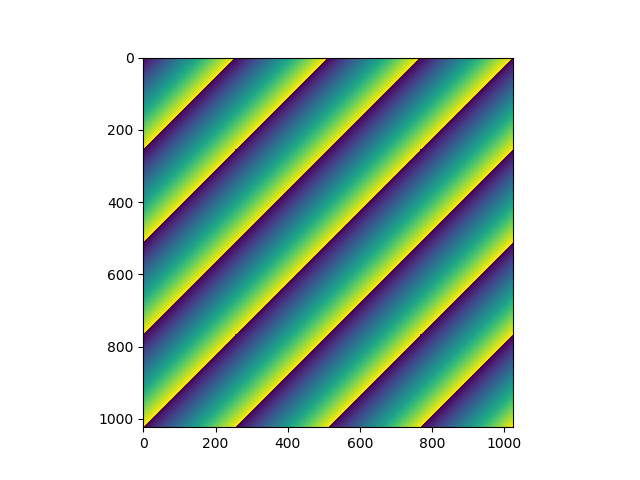

In [8]:
from instrument.mpl import plt

# The image comes from EPICS AD as a 1-D array, row by row.
# We need to make it into a 2-D array, so first we need to
# get the number of rows and columns from the image plugin.

array_size = adsimdet.image.array_size.get()
shape = (array_size.height, array_size.width)

# Now, get the image and make it a 2-D array.
im = adsimdet.image.array_data.get().reshape(shape)

# Tell MatPlotLib to show the image.
plt.imshow(im)

It's useful to make these steps into a Python function.

In [9]:
def show_ad_image(det):
    array_size = det.image.array_size.get()
    shape = (array_size.height, array_size.width)
    im = det.image.array_data.get().reshape(shape)
    plt.imshow(im)

<IPython.core.display.Javascript object>


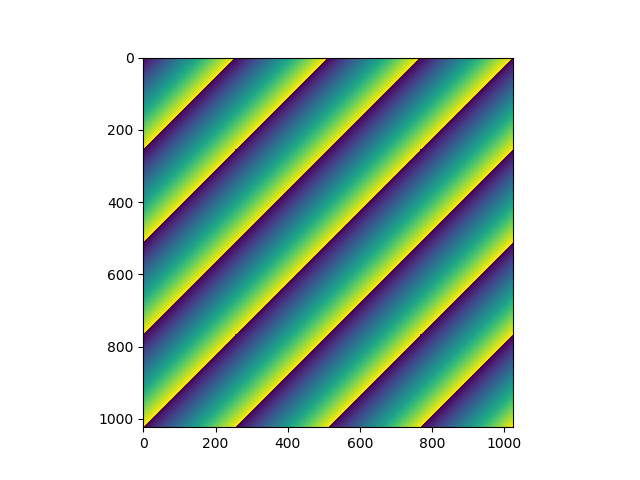

In [10]:
plt.close()   # stop interaction with previous MPL window
show_ad_image(adsimdet)

----

Save image(s) to HDF5 file.

In [11]:
from ophyd.areadetector import ADComponent
from ophyd.areadetector import EpicsSignalWithRBV
from ophyd.areadetector import HDF5Plugin
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite

class MyHDF5Plugin(HDF5Plugin, FileStoreHDF5IterativeWrite):
    create_directory_depth = Component(EpicsSignalWithRBV, suffix="CreateDirectory")
    array_callbacks = Component(EpicsSignalWithRBV, suffix="ArrayCallbacks")

    pool_max_buffers = None
    
    def get_frames_per_point(self):
        return self.num_capture.get()

    def stage(self):
        super().stage()
        res_kwargs = {'frame_per_point': self.get_frames_per_point()}
        # res_kwargs = {'frame_per_point': self.num_capture.get()}
        self._generate_resource(res_kwargs)

In [12]:
DATABROKER_ROOT_PATH = "/tmp/"

# note: AD path MUST, must, MUST have trailing "/"!!!
#  ...and... start with the same path defined in root (above)

# path as seen by detector IOC
WRITE_HDF5_FILE_PATH = "/tmp/simdet/%Y/%m/%d/"
#!!! NOTE !!! This filesystem is on the IOC (might be in a docker container)!

# path as seen by databroker
READ_HDF5_FILE_PATH = "/tmp/docker_ioc/iocadsky/tmp/simdet/%Y/%m/%d/"

In [13]:
class MySingleTriggerSimDetector(SingleTrigger, SimDetector): 
       
    image = Component(ImagePlugin, suffix="image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        suffix='HDF1:', 
        root=DATABROKER_ROOT_PATH,
        write_path_template = WRITE_HDF5_FILE_PATH,
        read_path_template = READ_HDF5_FILE_PATH,
    )

In [14]:
adsimdet = MySingleTriggerSimDetector(_ad_prefix, name='adsimdet')
adsimdet.stage_sigs["cam.num_images"] = 1
adsimdet.stage_sigs["cam.acquire_time"] = 0.1
adsimdet.stage_sigs["cam.acquire_period"] = 0.25
adsimdet.hdf1.stage_sigs["num_capture"] = 1

adsimdet.read_attrs.append("hdf1")
if adsimdet.hdf1.create_directory_depth.get() == 0:
    # probably not set, so let's set it now to some default
    adsimdet.hdf1.create_directory_depth.put(-5)

NOTE: EPICS AreaDetector file-saving plugins (such as 
the HDF plugin) must be primed before they can be 
used.  Priming must be done in these situations:

* the IOC has just started
* the image size has changed

If you do not prime the detector and its plugin chain, *ophyd* will report an *UnprimedPlugin* error like this if you try to trigger (acquire data from) the detector:

```
UnprimedPlugin: The plugin hdf1 on the area detector with name DETECTOR_NAME has not been primed.
```

To prime the HDF plugin, call its `warmup()` method.

In [15]:
enabled = adsimdet.hdf1.enable.get()
adsimdet.hdf1.warmup()
adsimdet.hdf1.enable.put(enabled)

In [16]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('auto_increment', 'Yes'),
             ('array_counter', 0),
             ('auto_save', 'Yes'),
             ('num_capture', 1),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Stream'),
             ('capture', 1),
             ('blocking_callbacks', 'Yes'),
             ('parent.cam.array_callbacks', 1)])

In [17]:
print(f"frames/point: {adsimdet.hdf1.get_frames_per_point()}")
RE(bp.count([adsimdet]))

frames/point: 1


Transient Scan ID: 2     Time: 2020-05-09 19:25:44
Persistent Unique Scan ID: '346a6ebf-a098-45c2-b070-92053ef8e1be'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 19:25:44.2 |
+-----------+------------+
generator count ['346a6ebf'] (scan num: 2)


('346a6ebf-a098-45c2-b070-92053ef8e1be',)

----

Now, use databroker to retrieve that data and show the image.

In [18]:
h = db[-1]

<IPython.core.display.Javascript object>


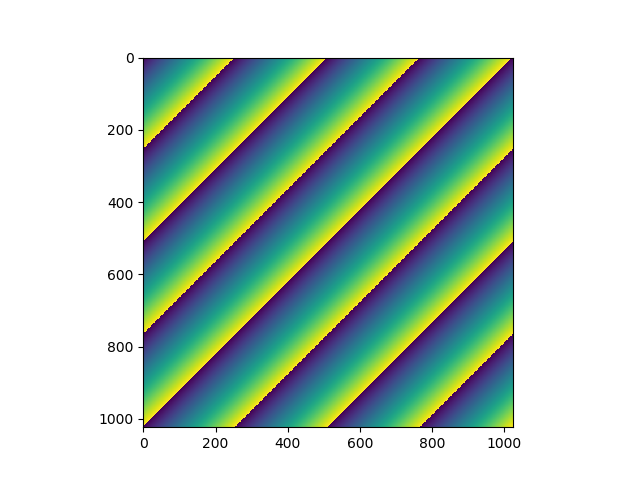

In [19]:
plt.close()   # stop interaction with previous MPL window
plt.imshow(h.xarray().adsimdet_image[0][0])